<a href="https://colab.research.google.com/github/cernavcii/MyFirstRepo/blob/main/Orange_telco_churn_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Veri Seti Hakkında**


Orange Telecom'un temizlenmiş müşteri etkinliği verilerinden (özellikler) oluşan ve bir müşterinin aboneliği iptal edip etmediğini belirten bir churn etiketi içeren Churn Veri Seti, tahmine dayalı modeller geliştirmek için kullanılacaktır. Burada iki veri seti mevcuttur: Churn-80 ve churn-20 veri setleri.

İki set aynı partidendir, ancak 80/20 oranında bölünmüştür. ML modelleri geliştirmek için genellikle daha fazla veri istendiğinden, daha büyük seti (yani churn-80) eğitim ve çapraz doğrulama amaçları için ve daha küçük seti (yani churn-20) son test ve model performans değerlendirmesi için kullanılacktır.

* State (Eyalet)
* Account length (Hesap uzunluğu)
* Area code (Alan kodu)
* International plan (Uluslararası plan)
* Voice mail plan (Sesli posta planı)
* Number vmail messages (Vmail mesaj sayısı)
* Total day minutes (Toplam gün dakikaları)
* Total day calls (Toplam gün aramaları)
* Total day charge (Toplam gün ücreti)
* Total eve minutes (Toplam akşam dakikaları)
* Total eve calls (Toplam akşam aramaları)
* Total eve charge (Toplam akşam ücreti)
* Total night minutes (Toplam gece dakikaları)
* Total night calls (Toplam gece aramaları)
* Total night charge (Toplam gece ücreti)
* Total intl minutes (Toplam uluslararası dakikalar)
* Total intl calls (Toplam uluslararası aramalar)
* Total intl charge (Toplam uluslararası ücret)
* Customer service calls (Müşteri hizmetleri aramaları)
* Churn



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.metrics import f1_score,roc_auc_score, roc_curve, auc
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Veriyi yükleyelim
train=pd.read_csv('churn-80.csv')
test=pd.read_csv('churn-20.csv')
df = pd.concat([train, test], ignore_index=True)

In [ ]:
# İlk birkaç satıra bakalım
df.head()


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [ ]:
# Eksik veri kontrolü
missing_values = df.isnull().sum()
missing_values[missing_values > 0]


,0


# **Exploratory Data Analysis (EDA)**

In [ ]:
# Kategorik değişkenleri dönüştürelim
df['International plan'] = df['International plan'].map({'No': 0, 'Yes': 1})
df['Voice mail plan'] = df['Voice mail plan'].map({'No': 0, 'Yes': 1})

# State değişkenini Label Encoding ile sayısal hale getirelim
le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])

# Hedef değişkeni sayısal hale getirelim
df['Churn'] = df['Churn'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   int64  
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   int64  
 4   Voice mail plan         3333 non-null   int64  
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


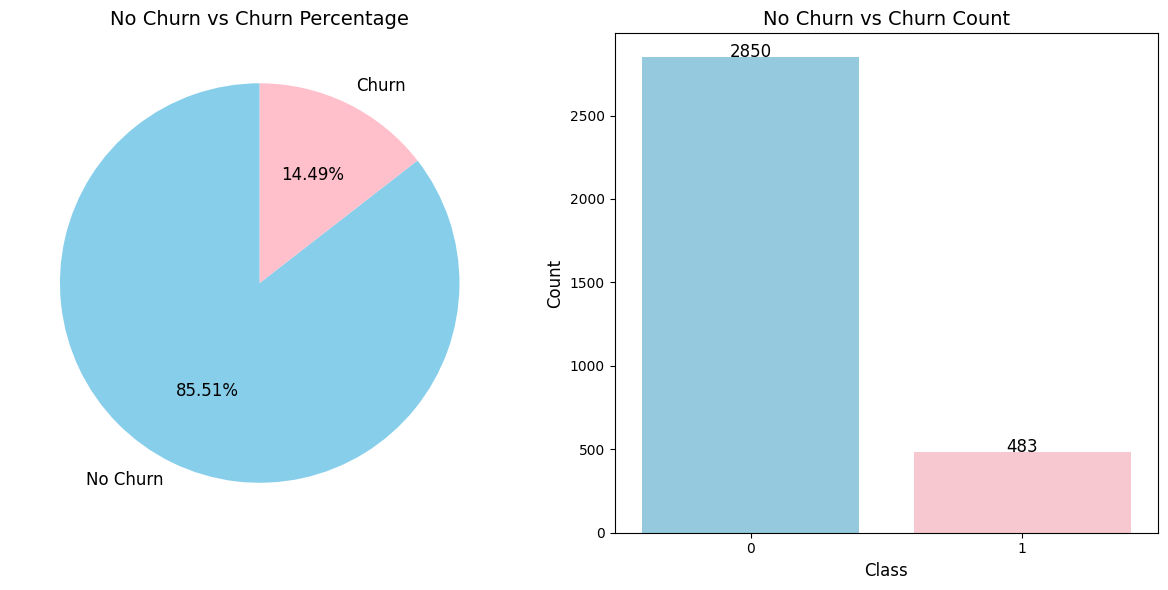

In [ ]:
# Hedef değişken 'Churn'de sınıf dengesizliği olup olmadığını değerlendirelim
# hedef sütundaki her sınıfın oluşumlarını say
class_counts = df['Churn'].value_counts()

# olayların yüzdesini hesapla
percentages = class_counts / len(df) * 100
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# pie chart
axes[0].pie(
    percentages,
    labels=['No Churn', 'Churn'],
    autopct='%1.2f%%',
    startangle=90,
    colors=['skyblue', 'pink'],
    textprops={'fontsize': 12}
)
axes[0].set_title('No Churn vs Churn Percentage', fontsize=14)


# bar plot
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    ax=axes[1],
    palette=['skyblue', 'pink']
)
for i, count in enumerate(class_counts.values):
    axes[1].text(i, count, f'{count}', ha='center', fontsize=12)
axes[1].set_title('No Churn vs Churn Count', fontsize=14)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

Veri setinde churn oranının düşük olduğunu ve dengesiz (imbalanced) bir dağılım olduğunu gösteriyor. Bu tür bir dengesizlik, model eğitimi sırasında yanlış tahminlere ve bias'a neden olabilir. İlerleyen adımlarda dengelemek için SMOTE, sınıf ağırlıklarıyla dengeleme veya undersampling/oversampling gibi teknikler kullanılacaktır.

<Axes: >

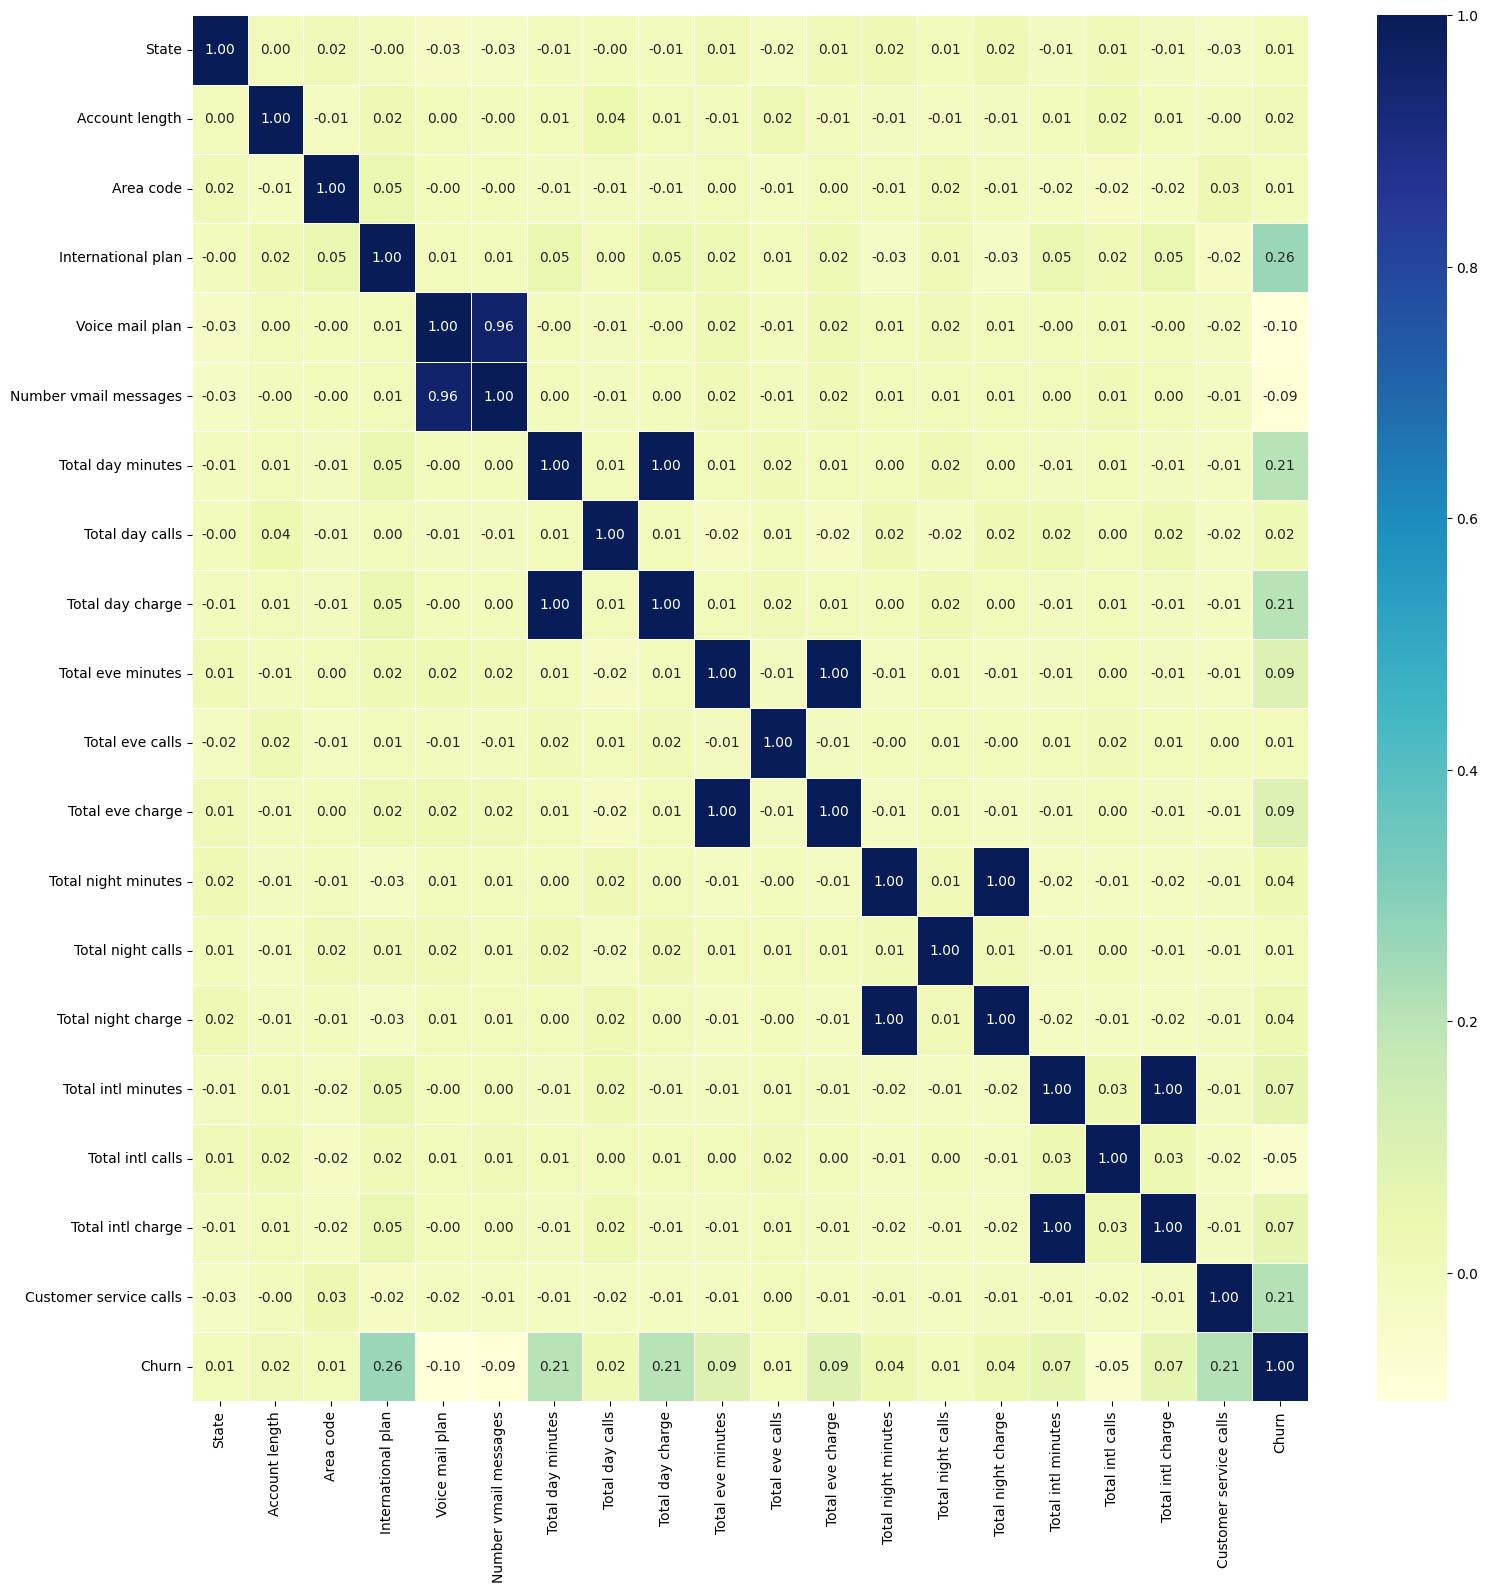

In [ ]:
# özellikler arasındaki korelasyonu kontrol edilmesi
# sayısal özellikler arasındaki korelasyonlar
plt.figure(figsize=(18,18))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="YlGnBu",fmt=".2f",linewidths=0.5)

Yüksek korelasyon gösteren değişkenler:

*   Total day minutes ↔ Total day charge (1.00)
*   Total eve minutes ↔ Total eve charge (1.00)
*   Total night minutes ↔ Total night charge (1.00)
*   Total intl minutes ↔ Total intl charge (1.00)0)

Bu, mantıklı çünkü dakika arttıkça ücret de artıyor. Aynı bilgiyi içerdiklerinden, modelleme öncesinde biri çıkarılabilir (multicollinearity sorunu olmaması için).

*Multicollinearity: bağımsız değişkenler (features) arasında yüksek doğrusal ilişki (korelasyon) olması durumudur.

In [ ]:
# Karşılıklı Bilgi (MI) Puanları¶
# Hedef değişken 'Churn' açısından her bir özelliğin alakalılığını değerlendirmek için Karşılıklı Bilgi (MI) puanlarını hesaplayın.

In [ ]:
# Bazı önemli özelliklerin churn dağılımı
# önemli özelliklerin dağılımının churn durumuna göre nasıl değişiklik gösterdiği

sns.set_palette(['skyblue', 'pink'])

features = ['International plan', 'Voice mail plan','Customer service calls']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f"Churn Distribution by {feature}")
    plt.show()

In [ ]:
# Aykırı değerler
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

aykiri_degerler = (df < alt_sinir) | (df > ust_sinir)
print(aykiri_degerler.sum())  # Her sütundaki aykırı değer sayısı


State                       0
Account length             18
Area code                   0
International plan        323
Voice mail plan             0
Number vmail messages       1
Total day minutes          25
Total day calls            23
Total day charge           25
Total eve minutes          24
Total eve calls            20
Total eve charge           24
Total night minutes        30
Total night calls          22
Total night charge         30
Total intl minutes         46
Total intl calls           78
Total intl charge          49
Customer service calls    267
Churn                     483
dtype: int64


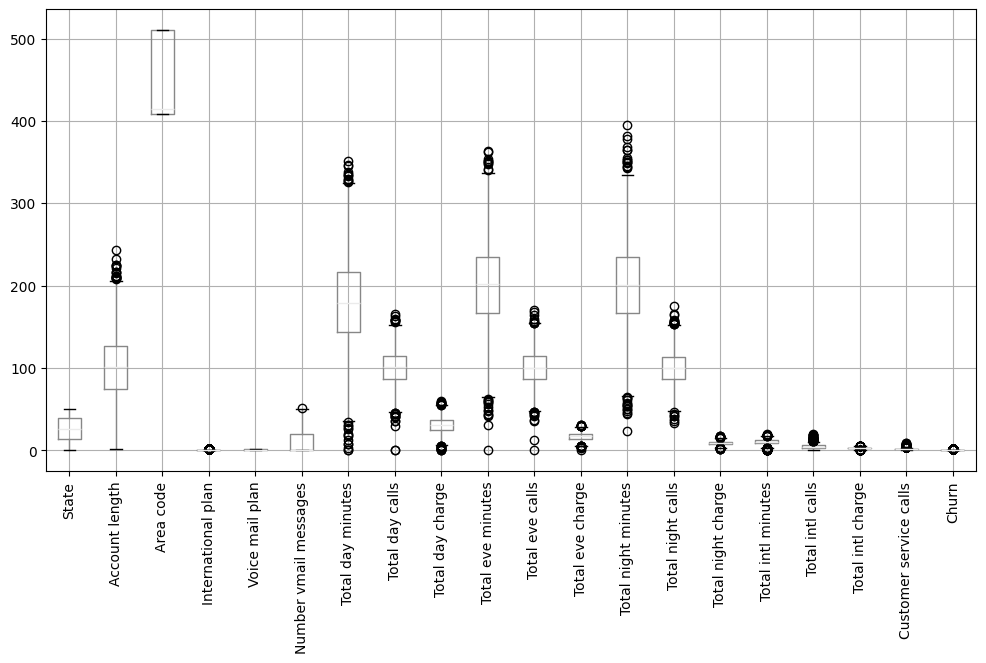

In [ ]:
import matplotlib.pyplot as plt

df.boxplot(figsize=(12,6))
plt.xticks(rotation=90)  # X eksenindeki isimleri döndür
plt.show()


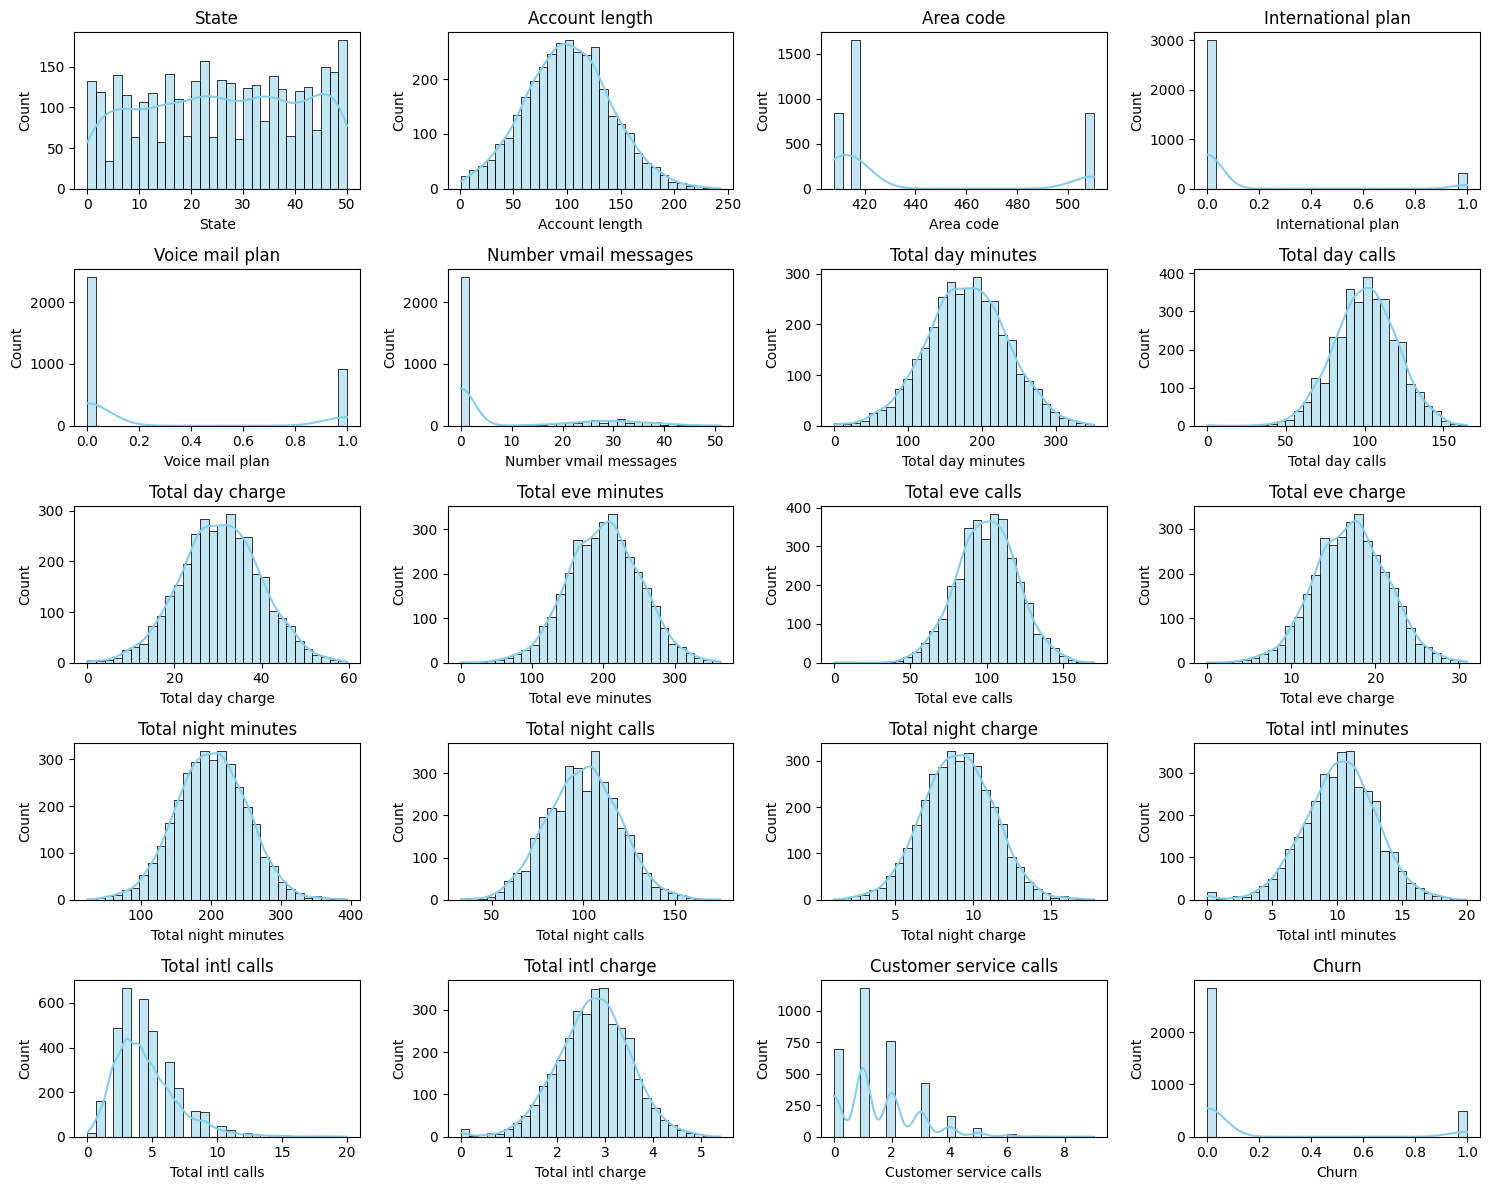

In [ ]:
# veriler normal dağılıma uyuyor mu ?
# Sadece sayısal değişkenleri seçelim
numeric_columns = df.select_dtypes(include=['number']).columns

# Grafikleri çizelim
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 4, i)  # 5 satır, 4 sütunluk bir grafik alanı oluşturduk
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()  # Grafiklerin üst üste binmesini önler
plt.show()


 **EDA sonuçları**

* Veri seti eksik değer veya yinelenen kayıt olmadan tamamlanmıştır.
* Veri seti çoğu değişkende yaklaşık olarak normal dağılım göstermektedir.
* Özelliklerin ölçekleri çok farklıdır.
* Sınıf dağılımı dengesizlik göstermektedir (çoğunluk müşteri kaybetmemiş müşterilerdir).
* İlgili özellikler (dakikalar ve ücretler) arasında çoklu doğrusallık tespit edilmiştir.
* Daha yüksek hizmet kullanımı ve ücretler artan müşteri kaybetme olasılığıyla ilişkilidir.
* Coğrafi konum (Eyalet) müşteri kaybetme durumu üzerinde önemli bir etkiye sahiptir.
* Aykırı değerler tespit edilmiştir ancak geçerli müşteri davranışını temsil ettikleri için tutulacaktır.

# **Veri Ön İşleme**

In [ ]:
# Çoklu doğrusallık (multicollinearity)
# çoklu doğrusal özellikleri kaldır
columns = ['Total intl minutes', 'Total day minutes', 'Total night minutes', 'Total eve minutes']
df.drop(columns, axis = 1, inplace = True)

<Axes: >

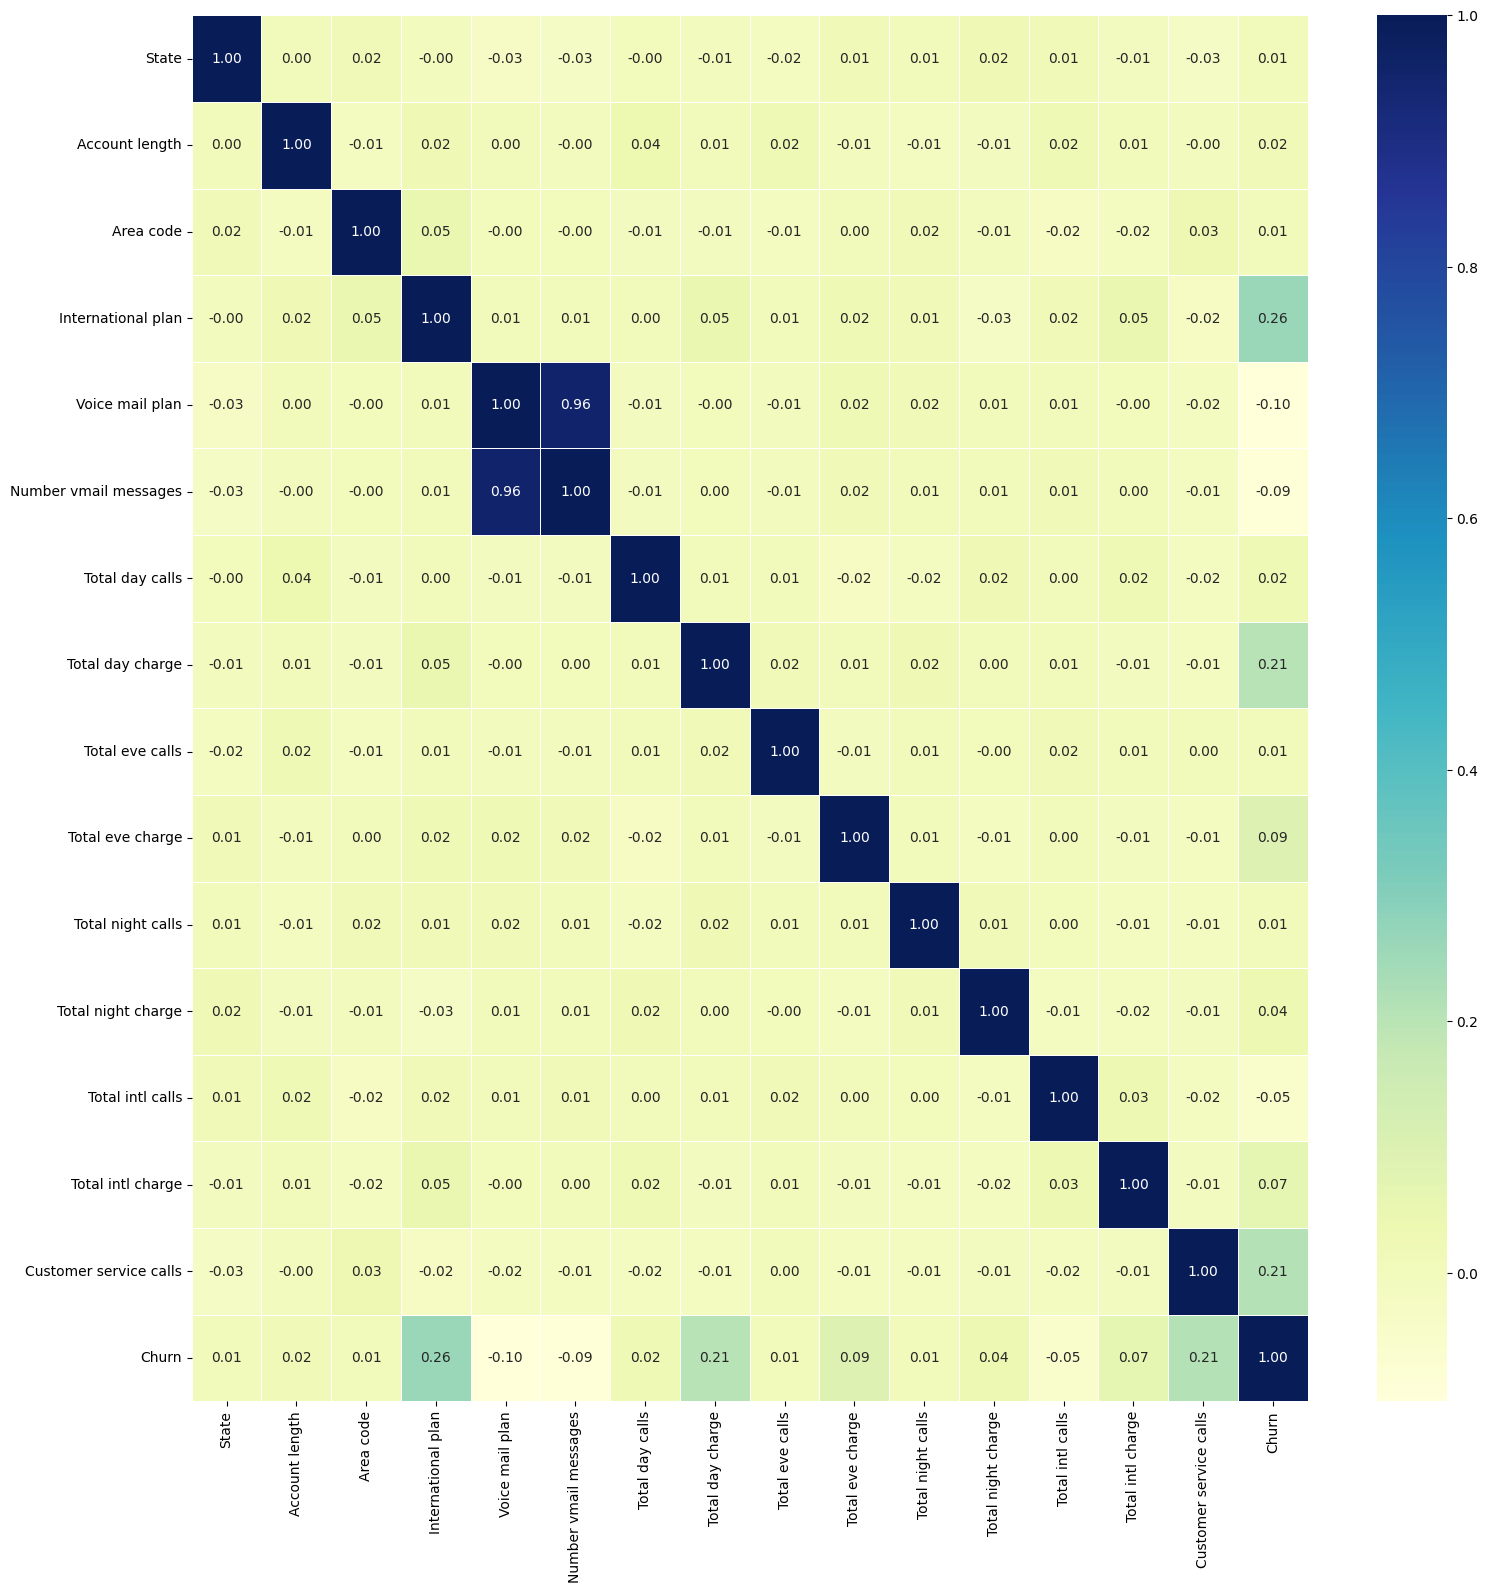

In [ ]:
# plot correlations
plt.figure(figsize=(18,18))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="YlGnBu",fmt=".2f",linewidths=0.5)

In [ ]:
# One Hot encode categorical column Area code:
# one hot encoding hiçbir sıralı ilişki mevcut olmadığından seçildi

data = pd.get_dummies(df, columns=['Area code'], prefix=['Area_code'])

In [ ]:
# split data
X = data.drop('Churn', axis=1)
y = data['Churn']

# verileri eğitim ve test kümelerine bölerek, hedef değişken 'Churn'e göre katmanlaştırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# target encode categorical column State:
# target encoding yüksek kardinalitesi nedeniyle 'State' sütunu için seçildi

# eğitim setindeki durum başına ortalama kayıp oranını hesapla
state_mean_churn = X_train.join(y_train).groupby('State')['Churn'].mean()

# encoding'i eğitim verilerine uygula
X_train['state_encoded'] = X_train['State'].map(state_mean_churn)

# encoding'i test verilerine uygula
X_test['state_encoded'] = X_test['State'].map(state_mean_churn)

# orijinal `State` sütununu şimdi kodlandığı gibi bırak
X_train.drop('State', axis=1, inplace=True)
X_test.drop('State', axis=1, inplace=True)

In [ ]:
# Sınıf dengesizliği :
# SMOTE aşırı örneklemeyi uygulama

# Sınıf dengesizliğini ele almak için eğitim setine SMOTE uygulayın
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
y_train_balanced.value_counts()


,count
Churn,
0,2280
1,2280


In [ ]:
# Özellik ölçeklemesi(feature scaling):
# StandardScaler, özelliklerin normal dağılımları nedeniyle seçildi

# Dengeli verileri ölçeklendir
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test)

X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
X_test_balanced = pd.DataFrame(X_test_balanced, columns=X_test.columns)

In [ ]:
# Dengesiz verileri ölçeklendir
x_train= scaler.fit_transform(X_train)
x_test= scaler.transform(X_test)
x_train = pd.DataFrame(x_train, columns=X_train.columns)
x_test = pd.DataFrame(x_test, columns=X_test.columns)

x_train.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Area_code_408,Area_code_415,Area_code_510,state_encoded
0,-1.864555,-0.327327,-0.616954,-0.591217,-1.676747,0.873117,0.743245,0.918338,0.443262,-2.757121,0.628584,-0.878605,-0.426912,-0.583414,1.001502,-0.572441,-0.539267
1,-1.637832,3.055050,1.620867,2.476994,-0.571218,0.309758,1.097219,1.055589,1.310946,-1.234625,0.628584,3.474391,-1.200637,-0.583414,-0.998501,1.746903,0.749560
2,1.838589,-0.327327,1.620867,0.504573,2.142354,0.770195,0.743245,0.178577,0.443262,0.419880,1.859586,0.762038,-0.426912,-0.583414,1.001502,-0.572441,0.541073
3,-0.907280,-0.327327,1.620867,1.088994,0.283055,0.813531,-0.015269,-0.235504,-1.292108,0.441881,-0.192084,-0.164132,-1.200637,-0.583414,1.001502,-0.572441,0.541073
4,1.359951,-0.327327,-0.616954,-0.591217,-0.370212,-0.313187,0.085866,0.045978,0.443262,-0.825399,-0.192084,1.727900,0.346812,1.714048,-0.998501,-0.572441,0.797548


# **Model Oluşturma ve Değerlendirme**

In [ ]:
def tune_and_evaluate_models(X_train, y_train, X_test, y_test, models, param_grids, cv, dataset_name):
    """
    Tune models using GridSearchCV and evaluate on test data

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - y_test: Test labels
    - models: Dictionary of models to tune
    - param_grids: Dictionary of parameter grids for each model
    - cv: Cross-validation strategy
    - dataset_name: String to identify the dataset (e.g., 'Unbalanced', 'Balanced')

    Returns:
    - Dictionary of results for each model
    """
    # Sonuçları saklamak için sözlük
    results = {}

    # Hesaplanacak metrikler
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    # Her modeli ayarlayın ve değerlendirin
    for name, model in models.items():
        print(f"\n--- Tuning {name} on {dataset_name} Dataset ---")

        # Perform Grid Search
        grid = GridSearchCV(
            model,
            param_grids[name],
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)

        # Get best model
        best_model = grid.best_estimator_
        best_params = grid.best_params_

        # Predictions
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Metrikleri hesapla
        model_metrics = {}
        for metric_name, metric_func in metrics.items():
            if metric_name in ['Precision', 'Recall', 'F1 Score']:
                model_metrics[metric_name] = metric_func(y_test, y_pred, average='weighted')
            elif metric_name == 'ROC AUC':
                try:
                    model_metrics[metric_name] = metric_func(y_test, y_pred_proba)
                except ValueError:
                    model_metrics[metric_name] = "Not applicable"
            else:
                model_metrics[metric_name] = metric_func(y_test, y_pred)

        # Store results
        results[name] = {
            'Best Model': best_model,
            'Best Params': best_params,
            'Metrics': model_metrics,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred),
            'y_pred_proba': y_pred_proba
        }

    return results

In [ ]:
# Cross-Validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grids
param_grids = {

    'DecisionTree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
    }
}

#değerlendirmek için modeller
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),

}

# eğitim setindeki sınıf dengesizliğine göre scale_pos_weight'ı hesapla
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Dengesizlik yönetimi için ağırlıklı kayıplı modeller
models_weighted_loss = {
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),

}

In [ ]:
# modelleri değerlendirme
# Dengesiz veri kümesindeki modelleri değerlendirin
unbalanced_results = tune_and_evaluate_models(
    x_train, y_train, x_test, y_test,
    models, param_grids, cv,
    dataset_name='Unbalanced'
)

# Dengeli veri kümesindeki modelleri değerlendirin (SMOTE))
balanced_results_smote = tune_and_evaluate_models(
    X_train_balanced, y_train_balanced,
    X_test_balanced, y_test,
    models, param_grids, cv,
    dataset_name='Balanced SMOTE'
)

# Dengesiz veri kümesindeki modelleri değerlendirin (Weighted Loss)
balanced_results_weighted_loss = tune_and_evaluate_models(
    x_train, y_train, x_test, y_test,
    models_weighted_loss, param_grids, cv,
    dataset_name='Unbalanced (Class-Weighted Models)'
)


--- Tuning DecisionTree on Unbalanced Dataset ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Tuning DecisionTree on Balanced SMOTE Dataset ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Tuning DecisionTree on Unbalanced (Class-Weighted Models) Dataset ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# Printing results
def print_results(results):
    for model_name, model_results in results.items():
        print(f"\n{model_name} Results:")
        print("Best Parameters:", model_results['Best Params'])
        print("\nMetrics:")
        for metric, value in model_results['Metrics'].items():
            print(f"{metric}: {value}")
        print("\nClassification Report:")
        print(model_results['Classification Report'])

print("\n--- Unbalanced Dataset Results ---")
print_results(unbalanced_results)

print("\n--- Balanced Dataset (SMOTE) Results ---")
print_results(balanced_results_smote)

print("\n--- Unbalanced Dataset (Class-Weighted Models) Results ---")
print_results(balanced_results_weighted_loss)


--- Unbalanced Dataset Results ---

DecisionTree Results:
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Metrics:
Accuracy: 0.9460269865067467
Precision: 0.9445642719180951
Recall: 0.9460269865067467
F1 Score: 0.9430861561574013
ROC AUC: 0.9135829263881353

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       570
           1       0.91      0.70      0.79        97

    accuracy                           0.95       667
   macro avg       0.93      0.84      0.88       667
weighted avg       0.94      0.95      0.94       667


--- Balanced Dataset (SMOTE) Results ---

DecisionTree Results:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

Metrics:
Accuracy: 0.37631184407796103
Precision: 0.8015860035158098
Recall: 0.37631184407796103
F1 Score: 0.4259688537437526
ROC AUC: 0.5608247422680412

Classification Report:
              precision    re

**1. Dengesiz Veri Seti (Unbalanced) :**
* Accuracy (0.946): Model genel olarak yüksek doğruluk sağlıyor.
* Precision (0.944): Yanlış pozitifleri düşük tutuyor, yani model "pozitif" sınıfı tahmin ettiğinde genellikle doğru tahmin ediyor.
* Recall (0.946): Gerçek pozitifleri iyi yakalıyor.
* F1 Score (0.943): Dengeli bir doğruluk gösteriyor.
* ROC AUC (0.914): Modelin sınıfları ayırt etme gücü oldukça iyi.

Dengesiz veri setinde model çok yüksek doğruluk ve F1 skoru almış, ancak verinin dengesiz olması nedeniyle azınlık sınıfını yeterince öğrenmemiş olabilir. Yüksek doğruluk yanıltıcı olabilir çünkü model çoğunluk sınıfını daha iyi tahmin ediyor olabilir.

**2. SMOTE ile Dengelenmiş Veri Seti :**
* Accuracy (0.376): Modelin doğruluğu ciddi şekilde düştü.
* Precision (0.802): Model "pozitif" dediğinde nispeten doğru tahmin ediyor.
* Recall (0.376): Gerçek pozitifleri yakalama oranı çok düşük.
* F1 Score (0.426): Düşük F1 skoru modelin dengesiz tahmin yaptığını gösteriyor.
* ROC AUC (0.561): Modelin ayırt etme gücü oldukça kötü.

SMOTE, azınlık sınıfın örneklerini artırarak veri setini dengelemeye çalışıyor. Ancak, bu durumda modelin genelleme yeteneği zarar görmüş. Muhtemelen SMOTE ile üretilen sentetik örnekler, modelin doğal veri dağılımını öğrenmesini engellemiş. Ayrıca, optimal hiperparametreler farklı olduğu için model aşırı veya eksik öğrenmiş olabilir.

**3. Sınıf Ağırlıklı Model (Class-Weighted) :**
* Accuracy (0.910): Doğruluk düşse de hala oldukça yüksek.
* Precision (0.921): Yanlış pozitif oranı düşük.
* Recall (0.910): Gerçek pozitifleri yakalama oranı çok iyi.
* F1 Score (0.914): Dengeli ve güvenilir bir sonuç veriyor.
* ROC AUC (0.895): Sınıfları iyi ayırt edebiliyor.

Sınıf ağırlıklı modelleme, dengesiz veri setini ele almak için iyi bir yaklaşım olmuş. SMOTE gibi yapay veri eklemeden, doğrudan azınlık sınıfına daha fazla ağırlık vererek modelin bu sınıfı daha iyi öğrenmesini sağlamış. Sonuç olarak, doğruluk biraz düşse de genel performans çok daha dengeli.

**Genel Sonuç:**

Modelinizin çoğunluk sınıfına aşırı duyarlı olması istenmiyorsa sınıf ağırlıklı modelleme en iyi seçenek gibi görünüyor.

Dengesiz veri seti modeli fazla iyimser gösteriyor.

SMOTE, bu durumda modelin tahmin gücünü önemli ölçüde düşürmüş, bu yüzden veri seti için uygun bir yöntem olmayabilir.